In [2]:
import numpy as np
import pandas as pd

#for nlp
import nltk
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

#text vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

#metrics
from sklearn.metrics import classification_report, accuracy_score

#import method releated to evaluation
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#for graphs
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Text Classification Case Study - Mobile Text Spam Detection
We first load the text data  "SMSSpamCollection"

Furthermore, we perform some simple preprocessing and split the data array into two parts:

1. `text`: A list of lists, where each sublists contains the contents of our emails
2. `y`: our SPAM vs HAM labels stored in binary; a 1 represents a spam message, and a 0 represnts a ham (non-spam) message. 

In [3]:
filename = 'SMSSpamData.csv'
df = pd.read_csv('movie_data_cat.csv', encoding='utf-8')

# Exercise
- Examine the df dataframe using functions such as df.head(10), df.columns and df.shape, df.describe
- How many text messages are contained in this dataset?

You will notice that the class labels column is categorical. This means that we must convert them to integers. 
The code in the next cell does this by creating a mapping between 'spam' to 1 and 'ham' to 0

In [4]:
df.describe

<bound method NDFrame.describe of                                                   review sentiment
0      In 1974, the teenager Martha Moxley (Maggie Gr...       pos
1      OK... so... I really like Kris Kristofferson a...       neg
2      ***SPOILER*** Do not read this, if you think a...       neg
3      hi for all the people who have seen this wonde...       pos
4      I recently bought the DVD, forgetting just how...       neg
5      Leave it to Braik to put on a good show. Final...       pos
6      Nathan Detroit (Frank Sinatra) is the manager ...       pos
7      To understand "Crash Course" in the right cont...       pos
8      I've been impressed with Chavez's stance again...       pos
9      This movie is directed by Renny Harlin the fin...       pos
10     I once lived in the u.p and let me tell you wh...       neg
11     Hidden Frontier is notable for being the longe...       pos
12     It's a while ago, that I have seen Sleuth (197...       neg
13     What is it about the 

In [6]:
class_mapping = {label:idx for idx,label in enumerate(np.unique(df['sentiment']))}

print(class_mapping)
class_labels = [x for x in class_mapping] # store the class labels for later

{'neg': 0, 'pos': 1}


In [8]:
#use the mapping dictionary to transform the class labels into integers

df["sentiment"] = df["sentiment"].map(class_mapping)


In [9]:
df.head(3)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0


## Why do we need to preprocess raw text?
User generated content particularly such as social media and text messaging normally contain non-word content.

Whilst some of this content will be useful (e.g. emoji for sentiment analysis) to a given task; others won't. 

Accordingly we use regular expressions to clean our text before we can continue with converting text messages into vectors which can then form input into a sklearn classification algorithm. 

Use the next cell to explore different messages and the types of html tage, emojis and special chars that are contained in this dataset. 

In [10]:
df.loc[15, 'review']

"I saw this movie on the strength of the single positive review and I can only imagine that guy is a shill.<br /><br />The acting of the female lead is actually quite good, but the entire film is just so excruciatingly boring I could hardly bear to sit through it. This is the very definition of dullness.<br /><br />So far, this film is rated as 8 out of 10 on 7 votes. That must mean the director, director's girlfriend, producer, actress and drinking buddies have given their own film a 10.<br /><br />For the rest of you, who simply want to be entertained or enjoy a good story, avoid this.<br /><br />This man on the street shall give it a 2 out of 10.<br /><br />FDA note: while this movie can be used as an aide to obtaining a good nights sleep, no medicinal value is implied or offered."

## Regular expressions to clean text

In [11]:
#import regular expressions to clean up the text
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text) # remove all html markup
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # findall the emoticons
    
    # remove the non-word chars '[\W]+'
    # append the emoticons to end 
    #convert all to lowercase
    # remove nose char for consistency
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', '')) 
    return text

In [12]:
preprocessor(df.loc[15, 'review'])

'i saw this movie on the strength of the single positive review and i can only imagine that guy is a shill the acting of the female lead is actually quite good but the entire film is just so excruciatingly boring i could hardly bear to sit through it this is the very definition of dullness so far this film is rated as 8 out of 10 on 7 votes that must mean the director director s girlfriend producer actress and drinking buddies have given their own film a 10 for the rest of you who simply want to be entertained or enjoy a good story avoid this this man on the street shall give it a 2 out of 10 fda note while this movie can be used as an aide to obtaining a good nights sleep no medicinal value is implied or offered '

In [13]:
# apply the preprocessor to the entire dataframe (i.e. column review)
df['review'] = df['review'].apply(preprocessor)

In [14]:
# download the stopwords if not done before (need an Internet connection)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/craigpirie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# A basic text pre-processing pipeline
The basic pipeline includes stopword removal, tokenising and stemming. 

In [15]:

stop = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

def tokenizer(text):
       return text.split()

def tokenizer_stemmer(text):
    return [stemmer.stem(word) for word in tokenizer(text)]#text.split()]


def stop_removal(text):
       return [w for w in text if not w in stop]

In [16]:
df.loc[180, 'review']

'we could still use black adder even today imagine rowan atkinson resuming the role of assistant to the prime minister played by the wonderful hugh laurie hugh is sensational as the dimwit prince george and edmund as his brilliant assistant i love the episode which kenneth connor guest stars as a british thespian every time edmund says macbeth the two thespians do a silly little act to ward off evil spirits it s the funniest things that you will see of course none of this brilliance and comedic genius could be without ben elton and richard curtis who are also behind the films like love actually the thin blue line four weddings and a funeral black adder is funny and almost too good for television humor can be smart sexy and funny all at one i was hoping last night on saturday night live that hugh laurie would pay homage to his background in british humor if the gang at snl did some research they would know what a treasure it was to have hugh laurie grace their stage '

In [17]:
print(preprocessor(df.loc[15, 'review']), "\n")
print(tokenizer(df.loc[15, 'review']), "\n")
print(tokenizer_stemmer(df.loc[15, 'review']), "\n")
print(stop_removal(df.loc[15, 'review']), "\n")

i saw this movie on the strength of the single positive review and i can only imagine that guy is a shill the acting of the female lead is actually quite good but the entire film is just so excruciatingly boring i could hardly bear to sit through it this is the very definition of dullness so far this film is rated as 8 out of 10 on 7 votes that must mean the director director s girlfriend producer actress and drinking buddies have given their own film a 10 for the rest of you who simply want to be entertained or enjoy a good story avoid this this man on the street shall give it a 2 out of 10 fda note while this movie can be used as an aide to obtaining a good nights sleep no medicinal value is implied or offered  

['i', 'saw', 'this', 'movie', 'on', 'the', 'strength', 'of', 'the', 'single', 'positive', 'review', 'and', 'i', 'can', 'only', 'imagine', 'that', 'guy', 'is', 'a', 'shill', 'the', 'acting', 'of', 'the', 'female', 'lead', 'is', 'actually', 'quite', 'good', 'but', 'the', 'enti

 # Exercise
 - Explore how each of the preprocessors can be applied to the an example message. 
 - Would you consider different rules for this dataset compared to the IMDB dataset?

#  Vectorisation of text data
Next lets prepare the data using the CountVectorizer to parse the text data into a bag-of-words model.
Thereafter fit a sklearn calssifier.
First we start by creating a basic train_test_split to check that the data is trasnformed correctly before setting up a comparative study.

In [18]:
from sklearn.model_selection import train_test_split

X = df.loc[:, 'review'].values
y = df.loc[:, 'sentiment'].values

text_train, text_test, y_train, y_test = train_test_split(X, y, 
                                                          random_state=42,
                                                          test_size=0.25,
                                                          stratify=y)

# CountVectorizer
This method converts the text into count vector or a binary vector. For details of the avaiable parameters please refer to 
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In particular read up on:
- how to vectorise with n_gram_range using different n-grams i.e. unigram, bigram etc- how to vectorise with 
- how to ignore terms that appear in less than a set number of documents with min_df; and conversely with max_df
- how to restrict the vocabulary with max_features
- how to set callable preprocessing steps with preprocessor


## Exercise 
Modify the code below to explore parameters such as min_df; max_df; max_features etc.

In [19]:
vectorizer = CountVectorizer()
vectorizer.fit(X) # Learn a vocabulary dictionary of all tokens in the raw documents.

X_train = vectorizer.transform(text_train)
X_test = vectorizer.transform(text_test)

In [20]:
print(X_train.shape)
print(X_test.shape)

(37500, 104056)
(12500, 104056)


In [21]:
print('Sice of the vocabulary or the number of features in the vector ', len(vectorizer.vocabulary_))

Sice of the vocabulary or the number of features in the vector  104056


In [22]:
print(vectorizer.get_feature_names()[2000:2020]) #Array mapping from feature integer indices to feature name

['aboriginals', 'aborigine', 'aboriginee', 'aborigines', 'aboriginies', 'aborigins', 'aborigone', 'abort', 'aborted', 'aborting', 'abortion', 'abortionist', 'abortionists', 'abortions', 'abortive', 'aborts', 'abos', 'abott', 'abou', 'abound']


### Training a Classifier on Text Features

Now that we have transformed our text into a vector form, we can train a classifier, for instance a logistic regression classifier, which is a fast baseline for text classification tasks:

In [23]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
clf.fit(X_train, y_train)

/Users/craigpirie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

We can now evaluate the classifier on the testing set. Let's first use the built-in score function, which is the rate of correct classification in the test set:

In [25]:
clf.score(X_test, y_test)

0.88952

We can also compute the score on the training set to see how well we do there:

In [26]:
clf.score(X_train, y_train)

0.9972266666666667

# Setting up a pipeline 
In the previous example we carried out several steps involving: count vectorising; tfidf transforming and then applying this to both the train and test before fitting a classifier for preditcion. 
This pipeline of trnasformation steps and the final prediction can be carried out by setting up a pipeline.
Instead of using the transformed vectors of X_train and Y_train ; we will use the original train and test which contained the text data i.e. text_train and text_test. These can then be sent through the transformation piepline steps. 

In [ ]:
pipeline = make_pipeline(
    CountVectorizer(),
    TfidfTransformer(),
    MultinomialNB())
#MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
pipeline.fit(text_train, y_train)
y_pred = pipeline.predict(text_test)
print('accuracy %s' % pipeline.score(text_test, y_test))
print(classification_report(y_test, y_pred,target_names=class_labels))



# Exercise
Modify the code above to:
- use a Multinomial Naive Bayes instead of a Logistic Regression classifier


# Setting up a gridsearch with Cross Validation
In the previous cells we calculated results based in a single test-train split. 
Ideally we want to do this using cross-validation. For this purpose we can use GridSearchCV.

First we will setup a parameter grid search for the TfidfVectorizer (which combines CountVectorizer() 
with TfidfTransformer().
Details of this function provides many possible parameters (see http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). 

Some of the common parameters you may want to explore are listed below with some examples settings:

min_df=1,  # min count for relevant vocabulary
    
max_features=4000,  # maximum number of features

strip_accents='unicode',  # replace all accented unicode char by their corresponding  ASCII char

analyzer='word',  # features made of words

token_pattern=r'\w{1,}',  # tokenize only words of 4+ chars

ngram_range=(1, 1),  # features made of a single tokens

use_idf=True,  # enable inverse-document-frequency reweighting

smooth_idf=True,  # prevents zero division for unseen words

In order to specify a specific parameter in a gridsearch we must use the estimator\__parameter syntax. 

For instance if we want to specify a specific value for min_df; we state it as; 'tfidfvectorizer\__min_df'

In the follow-on code we set up alternative values for a few parameters and use a pipeline to setup the cross validation study to search the best combination of parameter values. 

In [67]:
param_grid = [{'tfidfvectorizer__ngram_range': [(1, 1)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
               'tfidfvectorizer__stop_words': [stop, None], # use the stop dictionary of stopwords or not
               'tfidfvectorizer__max_features': [1000, 4000], # use the stop dictionary of stopwords or not
               'tfidfvectorizer__tokenizer': [tokenizer_stemmer]}, # use a tokeniser and the stemmer 
               ]

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        #max_features=4000,
                        min_df=7,
                        preprocessor=None)

pipeline = make_pipeline(TfidfVectorizer(strip_accents=None, lowercase=False, min_df=7, preprocessor=None), 
                         LogisticRegression(random_state=1))

gs_tfidf = GridSearchCV(pipeline, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=1) 

Next, we split dataset into 2 parts, to form the test and training. This will ensure that the cross validation takes place on the training data and final accuracy on the test.

In [68]:
text_train, text_test, y_train, y_test = train_test_split(X, y, 
                                                          random_state=42,
                                                          test_size=0.25,
                                                          stratify=y)
gs_tfidf.fit(text_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/craigpirie/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/craigpirie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/craigpirie/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ours

/Users/craigpirie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/craigpirie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   14.9s finished
/Users/craigpirie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidfvectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=False,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=7,
                                                        ngram_range=(1, 1),
                              

# Exercise
- Once the gridsearchCV is complete; access the best_params_ and print it
- use best_score_ to access the accuracy for the best parameter combination on the train set
- use the best_estimator_ to make predictions on the unseen text data i.e. text_test. You can use gs_tfidf.best_estimator_.score(text_test, y_test) to calculate the accuracy on test.
- Use classification_report() to provides a summary of performance.
- Try setting the different tfidfvectoriser params to find the best combination for this dataset. For instance change the parameters min_df and ngram_range of the TfidfVectorizer. How does that change the important features?
- Finally you may want to do a similar study on the IMDB dataset.

# Unsupervised Learning 

This is a family of machine learning algorithms used to draw inferences from datasets consisting of input data. Since the focus is away from class labels we refer to these as unsupervised.
The most common unsupervised learning method is cluster analysis, which is used for exploratory data analysis to find hidden patterns or grouping in data.
Clustering of documents is a common task and often used as a means to form indexes to search large collections of documents (e.g. indexing of web collections). 

## Document Clustering - Organizing clusters as a hierarchical tree
In agglomerative clustering method, at each stage, the pair of clusters with minimum between-cluster distance are merged. 
Once the distance matrix (dist) is computed the dendogram can be generated by stating a linkage method.
To cluster our documents it is best to work with a small sample of emails messages in order to visualise the dendogram. 
This can be controlled with setting the frac parameter. 

### Clustering the Spam dataset
We will study clustering using the same dataset we used before for text classification. However we will not be using the class labels as we did before. 

In [69]:
df_sample = df.sample(frac=0.05, random_state=1) # use a frac of the data
print(df_sample.shape)
labels = list(range(len(df_sample.index.values))) # labels are text message ids extracted from the data frame index
index = labels # need these for the dendogram

#a = list(range(len(df_sample.index.values)))
#labels = (list(map(str, a)))
#print(labels)
#variables = list(df_sample.columns.values)
#features = list(df_sample.columns.values)
#print(variables)
#np.array(labels).T.tolist()

(279, 2)


# Clean up the data further for clustering

In [71]:
from bs4 import BeautifulSoup

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [72]:
df_sample['sms_msg'] = df_sample['sms_msg'].apply(clean_text)

In [73]:
# example text messages
df_sample.iloc[0:10].sms_msg

1447    looks like u wil b getting headstart im leavin...
2032         noe la u wana pei bf oso rite k lor days den
4432                     2mro coming gym machan goodnight
4888    todays vodafone numbers ending 4882 selected r...
5276    hi hope ur day good back walk table booked hal...
5463                          ok thk got u wan 2 come wat
839     tried contact offer new video phone 750 anytim...
4427                                      something u ate
1247    know u mean king havin credit goin2bed night n...
1545                 completed degree use joining finance
Name: sms_msg, dtype: object

# Create a dataframe to hold the vectorised versions of the data

In [74]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_features=20, min_df=4, smooth_idf=True, stop_words='english',
                                 use_idf=True, tokenizer=tokenizer_stemmer, ngram_range=(1,1))

tfidf_matrix = tfidf_vectorizer.fit_transform(df_sample['sms_msg']) #fit the vectorizer to sms messages
terms = tfidf_vectorizer.get_feature_names()
#print(tfidf_matrix.shape)

#print(terms)
#print(tfidf_matrix)
#df_sample['smsVect'] = list(tfidf_matrix.toarray()) # create the corresponding vectorised representation
#z= list(tfidf_matrix.toarray())

#list(tfidf_matrix.toarray())
df3 = pd.DataFrame(list(tfidf_matrix.toarray()), columns = terms, index = index)
df3.head(3)

/Users/craigpirie/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,2,4,come,day,free,gt,hope,know,like,love,lt,night,number,ok,repli,text,time,u,ur,work
0,0.475309,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.44522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.758854,0.0,0.0
1,0.000000,0.0,0.0,0.804894,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.593419,0.0,0.0
2,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


### We can visualise this document x term matrix using a heatmap

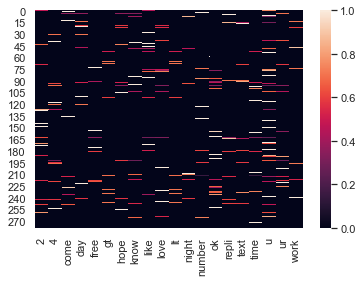

In [75]:
import seaborn as sns; sns.set()
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(df3)
ax.figure.savefig("heatmap.png")

## Performing hierarchical clustering on a distance matrix

In [76]:
from scipy.spatial.distance import pdist, squareform

row_dist = pd.DataFrame(squareform(pdist(df3.values, metric='euclidean')),
                        columns=index,
                        index=index)
print(row_dist)

          0         1         2         3         4         5         6    \
0    0.000000  1.048505  1.414214  1.414214  1.414214  0.936625  1.414214   
1    1.048505  0.000000  1.414214  1.414214  1.192233  1.228022  1.414214   
2    1.414214  1.414214  0.000000  1.414214  1.131889  0.935700  1.414214   
3    1.414214  1.414214  1.414214  0.000000  1.414214  1.414214  1.414214   
4    1.414214  1.192233  1.131889  1.414214  0.000000  1.263270  1.414214   
5    0.936625  1.228022  0.935700  1.414214  1.263270  0.000000  1.414214   
6    1.414214  1.414214  1.414214  1.414214  1.414214  1.414214  0.000000   
7    0.694472  0.901755  1.414214  1.414214  1.414214  1.082114  1.414214   
8    1.235292  1.276438  1.414214  1.414214  1.316270  1.319490  1.414214   
9    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
10   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
11   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

In [77]:

from scipy.cluster.hierarchy import linkage

row_clusters = linkage(df3.values, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,73.0,171.0,0.000000,2.0
cluster 2,260.0,279.0,0.000000,3.0
cluster 3,21.0,111.0,0.000000,2.0
cluster 4,222.0,281.0,0.000000,3.0
cluster 5,250.0,282.0,0.000000,4.0
cluster 6,2.0,13.0,0.000000,2.0
cluster 7,3.0,109.0,0.000000,2.0
cluster 8,203.0,221.0,0.000000,2.0
cluster 9,59.0,162.0,0.000000,2.0
cluster 10,185.0,287.0,0.000000,3.0


## Display the Dendogram

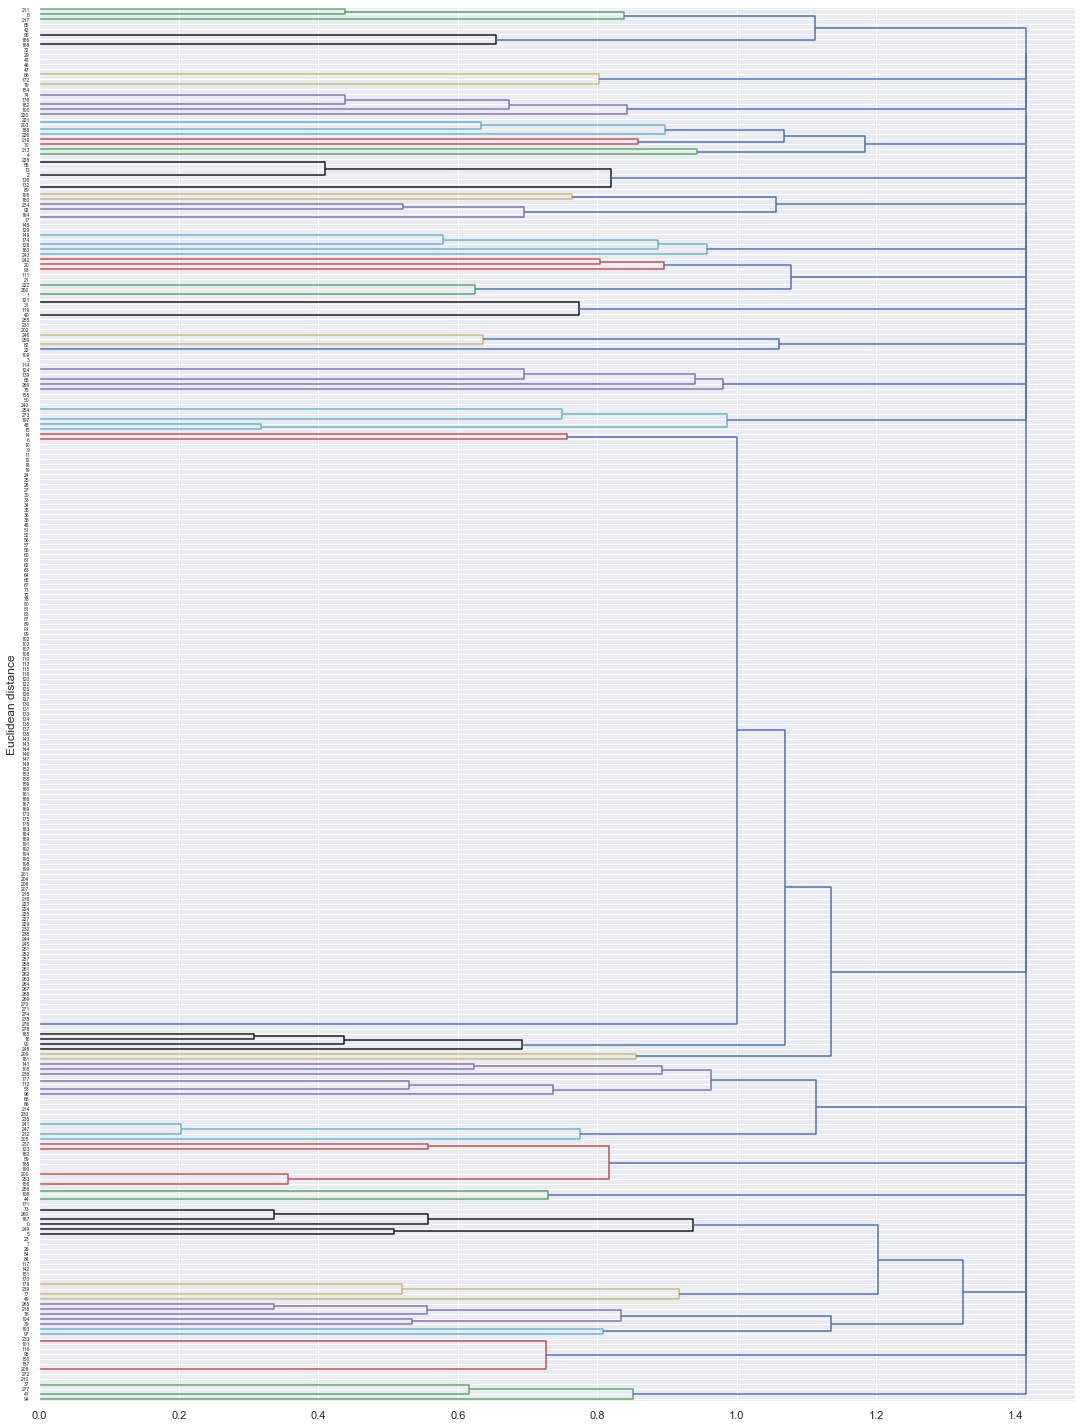

In [78]:
from scipy.cluster.hierarchy import dendrogram

#make dendrogram black (part 1/2)
#from scipy.cluster.hierarchy import set_link_color_palette
#set_link_color_palette(['black'])

fig, row_dendr = plt.subplots(figsize=(15, 20)) # set size

row_dendr = dendrogram(row_clusters, 
                       labels=labels,
                       orientation="right",
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                       )

plt.tight_layout()
plt.ylabel('Euclidean distance')
#plt.savefig('images/11_11.png', dpi=300, 
#            bbox_inches='tight')
plt.show()

## Exercise 
Change the linkage method from 'complete' to 'single' and create the dendogram. Do you notice any obvious differences? Single link tends to create straggly clusters compared to complete.

# Further visualisations with the seaborn library
seaborn provides some useful methods to display both the dendogram aswell as visualise the distances that led to the merging of instances (or text messages). 

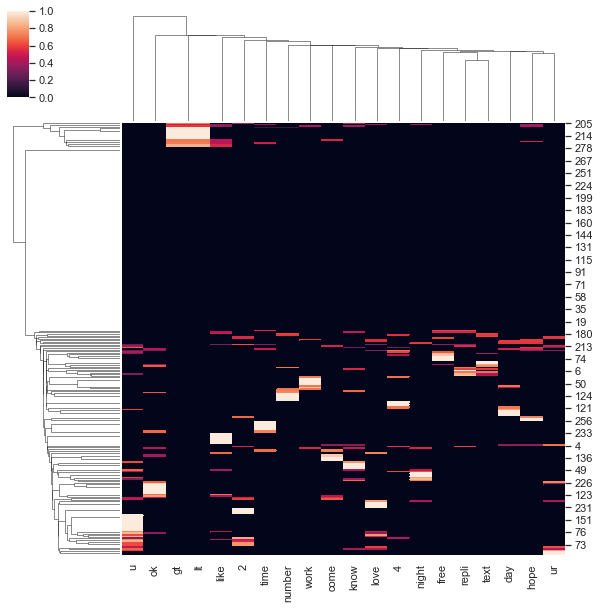

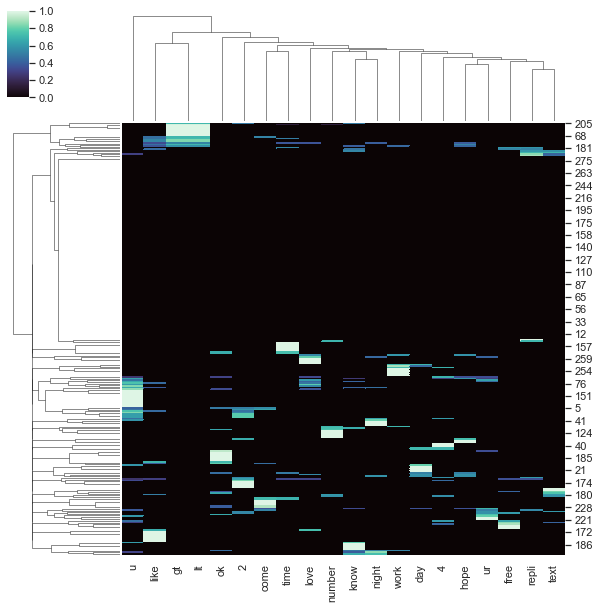

In [79]:
# Libraries
import seaborn as sns

 
# Data set
df3
 
# draw the dendogram.
# there are several linkage methods that can be used here
sns.clustermap(df3, metric="euclidean", standard_scale=1, method="single")
sns.clustermap(df3, metric="euclidean", standard_scale=1, method="complete", cmap="mako")
#sns.clustermap(df3, metric="euclidean", standard_scale=1, method="average", cmap="viridis")
#sns.clustermap(df3, metric="euclidean", standard_scale=1, method="complete", cmap="Blues")


# Explorations

The code above can be used to cluster any text collection you might want to manage. 
For instance we could use it to cluster similar movies from synopsis; or we could cluster similar books from their abstracts; or cluster friends in a network based on similar postings etc. 